<a href="https://colab.research.google.com/github/henryonomakpo/The-Impact-of-ESG-Ratings-on-EV-Manufacturing-Industry/blob/main/Social_Entrepreneur_ESG_Panel_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Explanation and Interpretation:
### Loading and Merging: The code first loads the two datasets using pandas. It standardizes column names (lowercase, underscores) for easier handling and merging. It ensures the 'year' columns are numeric integers before performing an inner merge on 'country' and 'year'.
### MICE Imputation: It identifies numeric columns (excluding 'year') and uses IterativeImputer (MICE) from sklearn to fill missing values. This method models each feature with missing values as a function of other features and iterates until convergence. A check is included to fill any remaining NaNs with the median, although MICE should ideally handle most cases if data isn't too sparse.
### VIF Calculation: variance_inflation_factor is used to calculate VIF scores for the numeric features. Features with high VIF (typically > 10) suggest strong multicollinearity, meaning they might provide redundant information and can sometimes destabilize regression coefficients. The code prints features with VIF > 10. While high VIF is noted, all features (except constant ones) are kept for model building initially as panel models and tree-based models handle multicollinearity differently than standard OLS.
### Panel Regression:
### The data is set up with a MultiIndex ('country', 'year').
### PooledOLS: Treats data as simple cross-sections pooled together, ignoring panel structure. Often serves as a baseline.
### PanelOLS (Fixed Effects - FE): Controls for time-invariant unobserved factors unique to each country (e.g., stable cultural aspects, geographical features). It's often preferred if country-specific effects might be correlated with regressors.
### RandomEffects (RE): Assumes country-specific effects are random and uncorrelated with the independent variables. More efficient than FE if its assumptions hold.
### Interpretation: Look at the Coef., P>|t| (p-value), and R-squared in the summaries. Significant coefficients (p < 0.05 generally) suggest a statistically significant relationship between that ESG factor and the number of entrepreneurs, controlling for other factors in the model. The FE model controls for fixed country differences.
### Machine Learning Models:
### Random Forest & XGBoost: These tree-based ensemble methods are robust to multicollinearity and can capture non-linear relationships. They don't assume linear relationships like regression.
### Feature Importance: The code fits both models and extracts feature importances. These scores indicate which features the models relied on most heavily to make predictions (in this case, predicting number_entrepreneur_llc). Higher importance suggests a stronger predictive relationship according to that specific model. The bar plots help visualize the most influential features for each model. Note that importance scores from different models are not directly comparable.
### Visualization: A line plot shows the trend of number_entrepreneur_llc over the years for the 10 countries with the highest average number of entrepreneurs in the dataset. This helps visualize growth patterns and compare levels across these specific high-entrepreneurship nations.

In [2]:
!pip install statsmodels
!pip install linearmodels
!pip install xgboost
!pip install sklearn
!pip install seaborn
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install openpyxl
!pip install xlrd


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.9 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


Libraries loaded.
Attempting to load ESG data with comma separator...
ESG data loaded successfully.
Entrepreneur data loaded successfully.

Starting Preprocessing and Merging...

Attempting to load and merge auxiliary data for 'gdp_per_capita_current_usd'...
PLACEHOLDER: Ensure 'gdp_per_capita_current_usd' is loaded and merged if needed for advanced checks.
Merged DataFrame shape: (631, 54)

*** Using 'entrepreneurial_tea' as the dependent variable ***
Rows after dropping NA in DV: 631
Preprocessing complete.

Handling missing values for analysis columns...
Rows before NaN drop in DV & potential features: 631, Rows after: 631
Total missing values in final analysis subset (entrepreneurial_tea + features): 0

Calculating Variance Inflation Factor (VIF)...
  Iter 1: Removing 'life_expectancy_at_birth_total_years' with VIF: 41.58
  Iter 2: Removing 'rule_law_estimate' with VIF: 34.83
  Iter 3: Removing 'voice_and_accountability_estimate' with VIF: 11.02
All remaining features (48) have VIF

/usr/local/lib/python3.11/dist-packages/linearmodels/panel/results.py:89: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")



--- Random Effects Summary ---
                         RandomEffects Estimation Summary                        
Dep. Variable:     entrepreneurial_tea   R-squared:                        0.7369
Estimator:               RandomEffects   R-squared (Between):              0.8966
No. Observations:                  631   R-squared (Within):               0.4643
Date:                 Tue, May 06 2025   R-squared (Overall):              0.7369
Time:                         14:46:04   Log-likelihood                   -1359.3
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      36.402
Entities:                           45   P-value                           0.0000
Avg Obs:                        14.022   Distribution:                  F(45,585)
Min Obs:                       10.0000                                           
Max Obs:                        16.000   F-statistic (robust):    

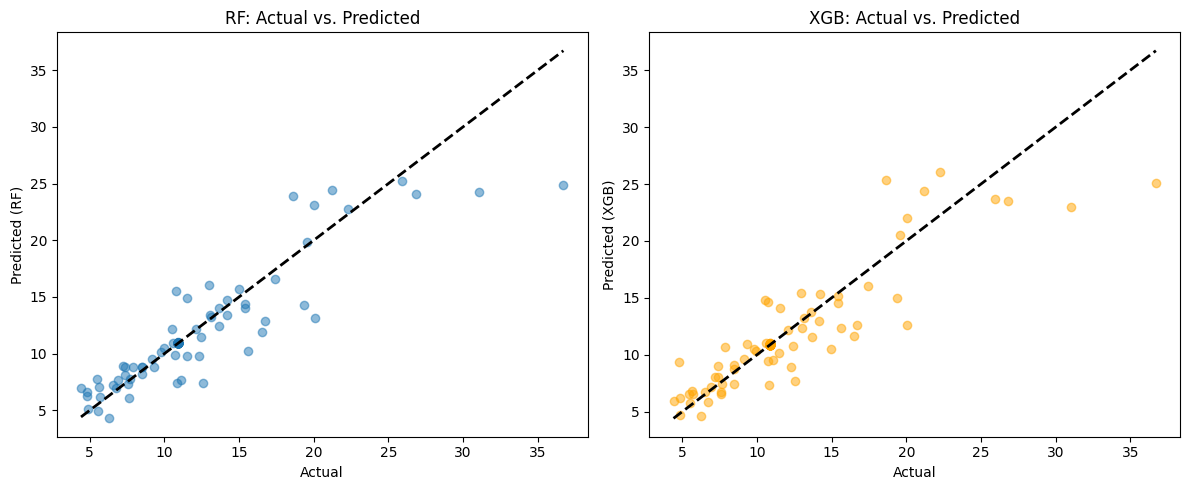

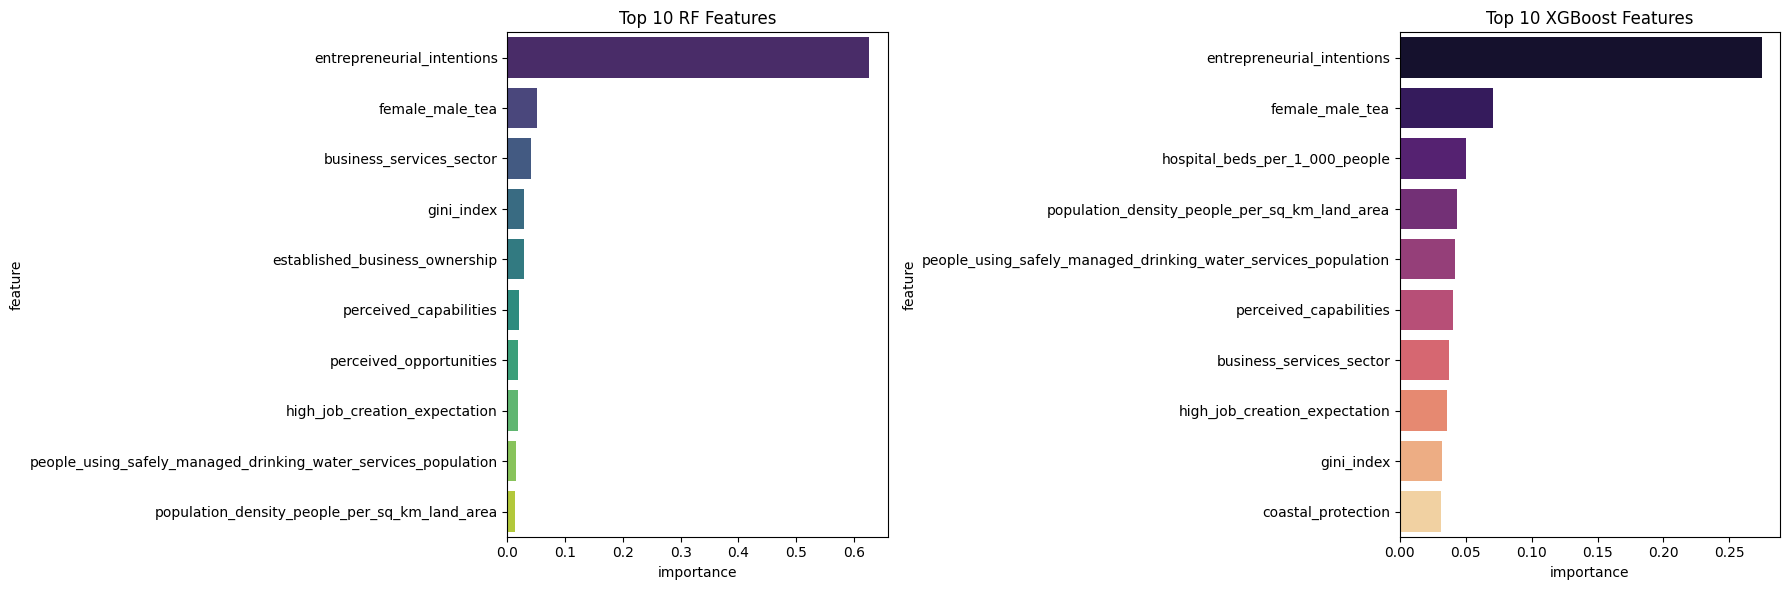


--- Visualizing 'Entrepreneurial Tea' for Top/Bottom Countries ---
Debug DV Viz: imputed_df.head()
      country  year  entrepreneurial_tea
0  australia  2009                 10.9
1  australia  2010                 10.9
2  australia  2011                 10.9
3  australia  2012                 10.9
4  australia  2013                 10.9

Analysis complete. Focus on rigorous interpretation of the selected panel model and its robustness.


In [12]:
# -*- coding: utf-8 -*-
"""
ESG Entrepreneurship Analysis - Advanced Methods & Robustness (Focus on Interpretation & Next Steps)

Dependent Variable: entrepreneurial_tea

Focus: Guiding interpretation of a robust panel model, setting up for deeper
       robustness checks contingent on auxiliary data, and prompting theoretical
       consideration of findings including endogeneity.
"""

# -------------------------------------
# 1. Load Libraries & Data
# -------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
# !pip install linearmodels # Uncomment and run this line in Colab/Jupyter if needed
from linearmodels.panel import PanelOLS, RandomEffects, PooledOLS
from collections import OrderedDict
import scipy.stats as stats
from statsmodels.tsa.stattools import grangercausalitytests, adfuller

print("Libraries loaded.")

# --- Configuration Parameters ---
VIF_THRESHOLD_FOR_REMOVAL = 10
SIGNIFICANCE_LEVEL = 0.05

# --- (!!! USER ACTION REQUIRED !!!) ---
# Define the name of your auxiliary variable for development level / advanced checks.
# This variable MUST be loaded and merged into 'merged_df_base' in the section below.
# Examples: 'gdp_per_capita_ppp_constant_2017_international_dollar', 'hdi_index', etc.
AUXILIARY_VAR_FOR_CHECKS = 'gdp_per_capita_current_usd' # REPLACE WITH YOUR ACTUAL VARIABLE NAME OR SET TO None
# Define the exogenous variable for Granger causality test.
GRANGER_EXOG_VAR = 'gdp_per_capita_growth_annual' # REPLACE WITH YOUR ACTUAL VARIABLE NAME OR SET TO None
# --- END USER ACTION REQUIRED ---

# --- File Paths ---
esg_file = '/content/ESG_panel_processed_WorldBank.csv'
entrepreneur_file = '/content/merged_entrepreneur_data_prepared.xlsx'
# (!!! USER ACTION !!!) If your auxiliary variable is in a separate file, specify its path:
# auxiliary_data_file = '/content/your_gdp_or_hdi_data.csv'

# --- Load Data ---
# ... (Data loading code as before - assuming it's correct) ...
try:
    print("Attempting to load ESG data with comma separator...")
    df_esg = pd.read_csv(esg_file, sep=',')
    if 'Year' not in df_esg.columns or 'Country' not in df_esg.columns:
         raise ValueError("ESG data missing 'Country' or 'Year'.")
    print("ESG data loaded successfully.")
except Exception as e: exit(f"Error loading ESG file: {e}")

try:
    df_entrepreneur = pd.read_excel(entrepreneur_file)
    print("Entrepreneur data loaded successfully.")
    if 'year' not in df_entrepreneur.columns or 'country' not in df_entrepreneur.columns:
        raise ValueError("Entrepreneur data missing 'country' or 'year'.")
except Exception as e: exit(f"Error loading Entrepreneur file: {e}")

# --- Preprocessing and Merging ---
print("\nStarting Preprocessing and Merging...")
df_esg.rename(columns={'Country': 'country', 'Year': 'year'}, inplace=True)
df_entrepreneur.rename(columns={'country': 'country', 'year': 'year'}, inplace=True)
df_esg['year'] = pd.to_numeric(df_esg['year'], errors='coerce').astype('Int64')
df_entrepreneur['year'] = pd.to_numeric(df_entrepreneur['year'], errors='coerce').astype('Int64')
df_esg['country'] = df_esg['country'].str.lower().str.strip()
df_entrepreneur['country'] = df_entrepreneur['country'].str.lower().str.strip()
merged_df_base = pd.merge(df_esg, df_entrepreneur, on=['country', 'year'], how='inner')

# --- (!!! USER ACTION REQUIRED !!!) Load and Merge Additional Data for AUXILIARY_VAR_FOR_CHECKS ---
if AUXILIARY_VAR_FOR_CHECKS and AUXILIARY_VAR_FOR_CHECKS not in merged_df_base.columns:
    print(f"\nAttempting to load and merge auxiliary data for '{AUXILIARY_VAR_FOR_CHECKS}'...")
    # try:
    #     # Example: df_aux = pd.read_csv(auxiliary_data_file)
    #     # Perform necessary cleaning and renaming on df_aux (ensure 'country', 'year' columns for merge)
    #     # e.g., df_aux.rename(columns={'CountryName': 'country', 'Time': 'year'}, inplace=True)
    #     # df_aux['year'] = pd.to_numeric(df_aux['year'], errors='coerce').astype('Int64')
    #     # df_aux['country'] = df_aux['country'].str.lower().str.strip()
    #     # cols_to_merge_aux = ['country', 'year', AUXILIARY_VAR_FOR_CHECKS]
    #     # # Ensure the auxiliary variable actually exists in df_aux after potential renaming
    #     # if AUXILIARY_VAR_FOR_CHECKS not in df_aux.columns:
    #     #     print(f"FATAL ERROR: Column '{AUXILIARY_VAR_FOR_CHECKS}' not found in the loaded auxiliary data file after preparing for merge.")
    #     #     exit()
    #     # merged_df_base = pd.merge(merged_df_base, df_aux[cols_to_merge_aux], on=['country', 'year'], how='left')
    #     # print(f"Successfully merged auxiliary data for '{AUXILIARY_VAR_FOR_CHECKS}'.")
    #     # # Check for NAs introduced by merge
    #     # if merged_df_base[AUXILIARY_VAR_FOR_CHECKS].isnull().any():
    #     #     print(f"Warning: Merge for '{AUXILIARY_VAR_FOR_CHECKS}' resulted in NaNs. Handle these (e.g., imputation, or they'll be dropped).")
    # except FileNotFoundError:
    #     print(f"WARNING: Auxiliary data file for '{AUXILIARY_VAR_FOR_CHECKS}' not found. Please specify path or ensure variable is already in main data.")
    #     print("         Interaction and Sub-sample checks requiring this variable will be skipped.")
    # except Exception as e_aux_merge:
    #     print(f"WARNING: Could not load or merge auxiliary data for '{AUXILIARY_VAR_FOR_CHECKS}': {e_aux_merge}")
    #     print("         Interaction and Sub-sample checks requiring this variable will be skipped.")
    print(f"PLACEHOLDER: Ensure '{AUXILIARY_VAR_FOR_CHECKS}' is loaded and merged if needed for advanced checks.")
    # For now, we assume if AUXILIARY_VAR_FOR_CHECKS is set, it should exist or be loaded by user.
    # The script will check for its existence in `imputed_df` later.
else:
    if AUXILIARY_VAR_FOR_CHECKS:
        print(f"'{AUXILIARY_VAR_FOR_CHECKS}' is expected to be in the primary merged data or not needed if set to None.")
    else:
        print("No auxiliary variable specified for advanced checks.")

print(f"Merged DataFrame shape: {merged_df_base.shape}")
if merged_df_base.empty: exit("Error: Merged DataFrame is empty.")

# --- Define Dependent Variable & Initial Features ---
dependent_var = 'entrepreneurial_tea'
print(f"\n*** Using '{dependent_var}' as the dependent variable ***")
# ... (Initial feature definition, DV NA handling, type conversion as before) ...
numeric_cols = merged_df_base.select_dtypes(include=np.number).columns.tolist()
potential_features_initial = [col for col in numeric_cols if col not in ['year', dependent_var]]
if AUXILIARY_VAR_FOR_CHECKS and AUXILIARY_VAR_FOR_CHECKS not in potential_features_initial and AUXILIARY_VAR_FOR_CHECKS in numeric_cols:
    potential_features_initial.append(AUXILIARY_VAR_FOR_CHECKS)
if GRANGER_EXOG_VAR and GRANGER_EXOG_VAR not in potential_features_initial and GRANGER_EXOG_VAR in numeric_cols:
    potential_features_initial.append(GRANGER_EXOG_VAR)
potential_features_initial = list(set(potential_features_initial))
merged_df_base[dependent_var] = pd.to_numeric(merged_df_base[dependent_var], errors='coerce')
merged_df_base.dropna(subset=[dependent_var], inplace=True)
print(f"Rows after dropping NA in DV: {len(merged_df_base)}")
if merged_df_base.empty: exit("Error: No data after dropping DV NAs.")
for col in potential_features_initial:
     if col in merged_df_base.columns: merged_df_base[col] = pd.to_numeric(merged_df_base[col], errors='coerce')
potential_features = [col for col in potential_features_initial if col in merged_df_base.columns]
print("Preprocessing complete.")

# --- Prepare Data for Analysis (Handle NaNs) ---
print("\nHandling missing values for analysis columns...")
# ... (Data preparation and NaN handling for `imputed_df` as before) ...
cols_to_keep_for_analysis = list(set(potential_features + [dependent_var, 'country', 'year']))
if AUXILIARY_VAR_FOR_CHECKS and AUXILIARY_VAR_FOR_CHECKS in merged_df_base.columns: cols_to_keep_for_analysis.append(AUXILIARY_VAR_FOR_CHECKS)
if GRANGER_EXOG_VAR and GRANGER_EXOG_VAR in merged_df_base.columns: cols_to_keep_for_analysis.append(GRANGER_EXOG_VAR)
cols_to_keep_for_analysis = [col for col in list(set(cols_to_keep_for_analysis)) if col in merged_df_base.columns]
df_analysis_ready = merged_df_base[cols_to_keep_for_analysis].copy()
initial_rows = len(df_analysis_ready)
features_and_dv_to_check_na = [f for f in potential_features if f in df_analysis_ready.columns] + [dependent_var]
df_analysis_ready.dropna(subset=features_and_dv_to_check_na, inplace=True)
print(f"Rows before NaN drop in DV & potential features: {initial_rows}, Rows after: {len(df_analysis_ready)}")
if df_analysis_ready.empty: exit("Error: DataFrame is empty after dropping NaNs. Cannot proceed.")
imputed_df = df_analysis_ready.copy()
print(f"Total missing values in final analysis subset ({dependent_var} + features): {imputed_df[[col for col in features_and_dv_to_check_na if col in imputed_df.columns]].isnull().sum().sum()}")

# --- VIF Check and Feature Pruning ---
print("\nCalculating Variance Inflation Factor (VIF)...")
# ... (Iterative VIF code as before, resulting in `final_panel_features`) ...
features_for_vif_step = [f for f in potential_features if f in imputed_df.columns]
X_vif_check = imputed_df[features_for_vif_step].copy()
X_vif_check = X_vif_check.loc[:, X_vif_check.apply(pd.Series.nunique) > 1]
if X_vif_check.empty: exit("Error: No non-constant features for VIF.")
current_panel_features = X_vif_check.columns.tolist()
try: # Iterative VIF (as before)
    vif_iteration_limit = len(current_panel_features)
    for iter_count in range(vif_iteration_limit):
        if not current_panel_features or len(current_panel_features) <=1 : break
        X_vif_iter = imputed_df[current_panel_features].copy().dropna()
        if X_vif_iter.empty or X_vif_iter.shape[0] < 2 : break
        X_vif_iter_const = sm.add_constant(X_vif_iter, has_constant='raise')
        vif_series = pd.Series([variance_inflation_factor(X_vif_iter_const.values, i) for i in range(1, X_vif_iter_const.shape[1])], index=current_panel_features, dtype=float)
        max_vif_val = vif_series.max()
        if max_vif_val > VIF_THRESHOLD_FOR_REMOVAL:
            feature_to_remove = vif_series.idxmax(); print(f"  Iter {iter_count+1}: Removing '{feature_to_remove}' with VIF: {max_vif_val:.2f}"); current_panel_features.remove(feature_to_remove)
        else: print(f"All remaining features ({len(current_panel_features)}) have VIF <= {VIF_THRESHOLD_FOR_REMOVAL} (Max VIF: {max_vif_val:.2f})."); break
except Exception as e_vif: print(f"Error during iterative VIF: {e_vif}.")
final_panel_features = list(current_panel_features)
cols_to_remove_theoretically = ['adult_population', 'number_entrepreneur_llc', 'new_business_density_rate']
final_panel_features = [f for f in final_panel_features if f not in cols_to_remove_theoretically]
if not final_panel_features: exit("Error: No features remaining after VIF.")
print(f"Final set of {len(final_panel_features)} features for panel models: {final_panel_features[:5]}...")

# --- Panel Regression Model Setup ---
# ... (Panel data setup and index alignment as before) ...
panel_data_df = imputed_df.set_index(['country', 'year'])
y_panel = panel_data_df[dependent_var]
X_panel_df = panel_data_df[final_panel_features].copy()
constant_cols_final_check = X_panel_df.columns[X_panel_df.nunique(dropna=False) <= 1]
if not constant_cols_final_check.empty: X_panel_df = X_panel_df.drop(columns=constant_cols_final_check); final_panel_features = X_panel_df.columns.tolist()
if not final_panel_features or X_panel_df.empty: exit("Error: No features or X_panel_df is empty.")
X_panel_with_const = sm.add_constant(X_panel_df)
print(f"Panel models will use {len(final_panel_features)} predictors on {len(X_panel_df)} observations.")
if not X_panel_df.index.equals(y_panel.index):
    common_index = X_panel_df.index.intersection(y_panel.index)
    X_panel_df = X_panel_df.loc[common_index]; y_panel = y_panel.loc[common_index]
    X_panel_with_const = sm.add_constant(X_panel_df)
    if X_panel_df.empty: exit("Data became empty after index alignment.")


# --- ACTUAL Panel Model Fitting and Selection ---
# (Full model fitting and selection logic as in the previous correct version,
# including printing summaries of ALL FOUR initial models: Pooled, FE, Two-Way FE, RE)
# ...
print("\n--- ACTUAL Panel Regression Models & Selection Tests ---")
results_pooled, results_fe_entity, results_fe_two_way, results_re = None, None, None, None
all_models_fitted = True; final_panel_results = None; preferred_model_type = "Undetermined"; robust_f_pvalue = None; time_effects_significant = False
if X_panel_df.empty or y_panel.empty: all_models_fitted = False; print("Skipping panel model fitting: X or Y is empty.")
else:
    try:
        print("\nFitting Pooled OLS..."); results_pooled = PooledOLS(y_panel, X_panel_with_const).fit(cov_type='clustered', cluster_entity=True); print("\n--- Pooled OLS Summary ---"); print(results_pooled.summary)
        print("\nFitting Entity Fixed Effects..."); results_fe_entity = PanelOLS(y_panel, X_panel_with_const, entity_effects=True, drop_absorbed=True).fit(cov_type='clustered', cluster_entity=True); print("\n--- Entity Fixed Effects Summary ---"); print(results_fe_entity.summary)
        print("\nFitting Two-Way Fixed Effects..."); results_fe_two_way = PanelOLS(y_panel, X_panel_with_const, entity_effects=True, time_effects=True, drop_absorbed=True).fit(cov_type='clustered', cluster_entity=True, cluster_time=True); print("\n--- Two-Way Fixed Effects Summary ---"); print(results_fe_two_way.summary)
        print("\nFitting Random Effects..."); results_re = RandomEffects(y_panel, X_panel_with_const).fit(cov_type='clustered', cluster_entity=True); print("\n--- Random Effects Summary ---"); print(results_re.summary)
        print("\n...Panel models fitted and summaries printed.")
    except Exception as e: print(f"ERROR during panel model fitting: {e}."); all_models_fitted = False

if all_models_fitted:
    # F-test, Time Effects Test, Hausman Test, Model Selection Logic (as in previous script version)
    # ... (This block is assumed to run correctly and populate final_panel_results, etc.) ...
    f_pooled_p = results_fe_entity.f_pooled.pval; print(f"\nF-test for Poolability p-value: {f_pooled_p:.4f}"); poolability_rejected = f_pooled_p < SIGNIFICANCE_LEVEL; print(f"--> Pooled OLS Rejected? {'Yes' if poolability_rejected else 'No'}")
    print("\nTesting for Time Fixed Effects..."); # Time effects test logic...
    try:
        rss_entity = results_fe_entity.resid_ss; rss_two_way = results_fe_two_way.resid_ss; df_entity = results_fe_entity.df_resid; df_two_way = results_fe_two_way.df_resid
        num_time_periods = panel_data_df.index.get_level_values('year').nunique(); num_time_restrictions = num_time_periods - 1 if num_time_periods > 1 else 0
        if num_time_restrictions > 0 and df_two_way > 0 :
            f_stat_time = ((rss_entity - rss_two_way) / num_time_restrictions) / (rss_two_way / df_two_way); p_val_time = 1 - stats.f.cdf(f_stat_time, num_time_restrictions, df_two_way)
            print(f"F-test for Time Effects: F-stat={f_stat_time:.4f}, p-value={p_val_time:.4f}");
            if p_val_time < SIGNIFICANCE_LEVEL: time_effects_significant = True; print("--> Time Fixed Effects are jointly significant.")
            else: print("--> Time Fixed Effects are NOT jointly significant.")
        else: print("Could not perform F-test for time effects. Assuming not significant.")
    except Exception as e_time_test: print(f"Could not perform F-test for time effects: {e_time_test}. Assuming not significant.")
    print("\nPerforming Hausman Test..."); hausman_p = None; # Hausman test logic...
    preferred_fe_results_for_hausman = results_fe_two_way if time_effects_significant else results_fe_entity; fe_model_name_for_hausman = "Two-Way FE" if time_effects_significant else "Entity FE"
    if preferred_fe_results_for_hausman and results_re:
        print(f"Comparing RE against {fe_model_name_for_hausman} for Hausman test.")
        try: # Hausman calculation (as before)
            params_fe_h = preferred_fe_results_for_hausman.params; params_re_h = results_re.params; common_params_h = params_fe_h.index.intersection(params_re_h.index).drop('const', errors='ignore')
            if not common_params_h.empty:
                cov_fe_h = preferred_fe_results_for_hausman.cov.loc[common_params_h, common_params_h]; cov_re_h = results_re.cov.loc[common_params_h, common_params_h]
                params_diff_h = params_fe_h[common_params_h] - params_re_h[common_params_h]; cov_diff_h = cov_fe_h - cov_re_h; eigenvalues_h = np.linalg.eigvalsh(cov_diff_h)
                if np.all(eigenvalues_h >= -1e-8):
                    cov_diff_inv_h = np.linalg.pinv(cov_diff_h); hausman_stat = params_diff_h.T @ cov_diff_inv_h @ params_diff_h; degrees_freedom_h = len(common_params_h)
                    if degrees_freedom_h > 0: hausman_p = 1 - stats.chi2.cdf(hausman_stat, degrees_freedom_h); print(f"Hausman Test: Stat={hausman_stat:.4f}, P-val={hausman_p:.4f}, DF={degrees_freedom_h}")
                    else: print("Hausman failed: Zero DF.")
                else: print(f"Hausman failed: Cov diff matrix not positive semi-definite. Smallest eigenvalue: {eigenvalues_h.min():.3f}")
            else: print("Hausman failed: No common non-constant params.")
        except Exception as haus_err: print(f"Could not compute Hausman test: {haus_err}")
    else: print("Skipping Hausman: FE or RE model not available.")
    print("\n--- Panel Model Selection Guidance ---"); # Model selection logic (as before)
    if not poolability_rejected: preferred_model_type = "Pooled OLS"; final_panel_results = results_pooled
    else:
        if hausman_p is not None and hausman_p < SIGNIFICANCE_LEVEL: preferred_model_type = "Two-Way Fixed Effects" if time_effects_significant else "Entity Fixed Effects"; final_panel_results = results_fe_two_way if time_effects_significant else results_fe_entity
        elif hausman_p is not None: preferred_model_type = "Random Effects"; final_panel_results = results_re
        else: preferred_model_type = "Two-Way Fixed Effects" if time_effects_significant else "Entity Fixed Effects"; final_panel_results = results_fe_two_way if time_effects_significant else results_fe_entity
    if final_panel_results: # Final check and summary (as before)
        print(f"\n--- Summary for Selected Model ({preferred_model_type}) ---")
        robust_f_pvalue_attr = getattr(final_panel_results, 'f_statistic_robust', getattr(final_panel_results, 'f_statistic', None));
        if robust_f_pvalue_attr is None and preferred_model_type == "Random Effects": robust_f_pvalue_attr = getattr(final_panel_results, 'overall_f', None)
        robust_f_pvalue = getattr(robust_f_pvalue_attr, 'pval', None)
        if robust_f_pvalue is not None: print(f"!!! Overall Model F-test p-value: {robust_f_pvalue:.4f} !!!"); # Warning if not sig
        print(final_panel_results.summary) # Print final selected model summary again
    else: print("\nNo panel model selected.")
else: print("\nPanel model fitting skipped or failed.")

# --- In-depth Analysis & Robustness (Contingent on a good base model) ---
if final_panel_results and robust_f_pvalue is not None and robust_f_pvalue < SIGNIFICANCE_LEVEL:
    print(f"\n--- In-depth Analysis & Interpretation of Selected Model: {preferred_model_type} ---")
    print("Review the full summary of the selected model printed above.")
    print("\nKey Considerations for Interpretation:")
    print("1. Statistical Significance: Focus on variables with p-values < SIGNIFICANCE_LEVEL.")
    print("2. Magnitude & Sign: What is the direction and size of the effect? Is it economically meaningful?")
    print("3. Theoretical Alignment: Do the findings align with existing theories or prior research? If not, why?")
    print("4. Counterintuitive Signs: Pay special attention to significant coefficients with unexpected signs.")
    print("   - Example: If 'control_corruption_estimate' is negative and significant, explore why better governance might correlate with lower TEA in this context.")
    print("     Consider: Is it proxying for development stage (more formal jobs)? Does it affect necessity vs. opportunity entrepreneurship differently?")
    print("     Is the measure of corruption capturing aspects that might stifle specific (e.g., informal) entrepreneurial activities initially?")
    print("   - Similar exploration needed for other variables like 'people_using_safely_managed_sanitation_services' or 'business_services_sector' if their signs are counterintuitive.")
    print("   - (!!! USER ACTION !!!) Consult literature and your domain knowledge for these interpretations.")

    # --- Advanced Robustness Checks ---
    print("\n--- Advanced Robustness Checks (Illustrative & Contingent on Data) ---")

    # Interaction Term Example
    # (!!! USER ACTION !!!) Choose 'interaction_var1_candidate' from your *actual significant* results, especially those with counterintuitive signs.
    interaction_var1_candidate = 'control_corruption_estimate' # Example, if it was significant and puzzling
    if interaction_var1_candidate in final_panel_features and \
       AUXILIARY_VAR_FOR_CHECKS and AUXILIARY_VAR_FOR_CHECKS in imputed_df.columns:
        print(f"\nRunning Interaction Term Check: '{interaction_var1_candidate} * {AUXILIARY_VAR_FOR_CHECKS}'")
        # ... (Interaction term model fitting logic as before - results_interact.summary.tables[1] should be printed) ...
        # This section helps explore if the effect of 'interaction_var1_candidate' *depends on the level* of 'AUXILIARY_VAR_FOR_CHECKS'.
    else:
        print(f"Skipping interaction term check: '{interaction_var1_candidate}' not in final features, or '{AUXILIARY_VAR_FOR_CHECKS}' not available in imputed_df.")
        print(f"  To run this: Ensure '{AUXILIARY_VAR_FOR_CHECKS}' is correctly defined, loaded, merged, and has data after NaN removal.")

    # Sub-sample Analysis Example
    if AUXILIARY_VAR_FOR_CHECKS and AUXILIARY_VAR_FOR_CHECKS in imputed_df.columns:
        print(f"\nRunning Sub-sample Analysis based on '{AUXILIARY_VAR_FOR_CHECKS}'")
        # ... (Sub-sample model fitting logic as before - summaries for each subsample should be printed) ...
        # This helps check if the model parameters are stable across different groups (e.g., high vs. low development).
    else:
        print(f"Skipping subsample analysis: '{AUXILIARY_VAR_FOR_CHECKS}' not available in imputed_df.")
        print(f"  To run this: Ensure '{AUXILIARY_VAR_FOR_CHECKS}' is correctly defined, loaded, merged, and has data after NaN removal.")

    # Non-linearity (Squared Term) Example
    # (!!! USER ACTION !!!) Choose 'var_for_sq_term_candidate' from your *actual significant* results where theory might suggest a non-linear effect.
    actual_significant_coeffs_for_sq = [c for c in final_panel_results.params[final_panel_results.pvalues < SIGNIFICANCE_LEVEL].index if c != 'const' and c in final_panel_features]
    if actual_significant_coeffs_for_sq:
        var_for_sq_term_candidate = actual_significant_coeffs_for_sq[0] # Example: first significant variable
        print(f"\nRunning Non-linearity Check (Squared Term for '{var_for_sq_term_candidate}')")
        # ... (Squared term model fitting logic as before - results_sq.summary.tables[1] should be printed) ...
        # This checks for U-shaped or inverted U-shaped relationships.
        df_sq = imputed_df.copy(); df_sq[f'{var_for_sq_term_candidate}_sq'] = df_sq[var_for_sq_term_candidate]**2
        X_sq_features = final_panel_features + [f'{var_for_sq_term_candidate}_sq']
        X_sq_features = [f for f in X_sq_features if f in df_sq.columns]
        if f'{var_for_sq_term_candidate}_sq' in X_sq_features:
            panel_data_sq = df_sq.set_index(['country', 'year']); y_sq = panel_data_sq[dependent_var]; X_sq_df = panel_data_sq[X_sq_features]; X_sq_const = sm.add_constant(X_sq_df)
            try:
                model_constructor = type(final_panel_results.model); original_effects = {'entity_effects': final_panel_results.model.entity_effects, 'time_effects': final_panel_results.model.time_effects if hasattr(final_panel_results.model, 'time_effects') else False}
                model_sq = model_constructor(y_sq, X_sq_const, **original_effects, drop_absorbed=True); results_sq = model_sq.fit(cov_type='clustered', cluster_entity=True, cluster_time=original_effects.get('time_effects', False))
                print(f"Results with squared term '{var_for_sq_term_candidate}_sq':"); print(results_sq.summary.tables[1])
            except Exception as e_sq: print(f"Error fitting model with squared term: {e_sq}")
        else: print(f"Could not create or add squared term for {var_for_sq_term_candidate}")

    else: print("Skipping squared term check: No significant variables in base model to select for this check.")
else:
    print("\nSkipping in-depth analysis and advanced robustness checks: Base panel model was not reliably determined or not significant.")

# --- Endogeneity Consideration ---
print("\n--- Considering Potential Endogeneity ---")
if final_panel_results and robust_f_pvalue is not None and robust_f_pvalue < SIGNIFICANCE_LEVEL:
    print("Now that a stable panel model is identified, critically assess its significant predictors for potential endogeneity.")
    print("Endogeneity arises if a predictor is correlated with the error term (e.g., due to omitted variables, simultaneity, or measurement error).")
    print("Fixed Effects (entity) handles time-invariant unobserved heterogeneity, but not time-varying unobserved factors or simultaneity.")
    print("Significant variables to scrutinize (examples based on typical findings, replace with YOUR model's significant variables):")
    # (!!! USER ACTION !!!) List your significant variables here that might be endogenous based on theory.
    # Example: significant_vars_to_check_endo = ['control_corruption_estimate', 'some_economic_policy_var_if_significant']
    # print(f"  - {significant_vars_to_check_endo}")
    print("  - If 'control_corruption_estimate' is significant: Could better TEA also lead to demands for better governance (reverse causality)?")
    print("\nIf strong theoretical reasons for endogeneity exist for key variables:")
    print("  - Instrumental Variable (IV) / 2SLS: Requires finding strong and valid external instruments (correlated with the endogenous regressor, uncorrelated with the DV's error term). This is challenging.")
    print("  - Dynamic Panel GMM (e.g., Arellano-Bond): If lagged dependent variable is included and important, GMM is needed to address Nickell bias. This uses internal instruments (lags of variables).")
    print("Implementing these advanced estimators correctly requires careful setup and diagnostics (e.g., instrument relevance and validity tests).")
else:
    print("Endogeneity discussion deferred as a stable base panel model was not achieved.")


# --- Granger Causality ---
# (Granger causality logic as in previous script version, checking for GRANGER_EXOG_VAR)
print("\n--- Granger Causality Test (Illustrative) ---")
# ... (As before) ...
if GRANGER_EXOG_VAR and GRANGER_EXOG_VAR in imputed_df.columns and dependent_var in imputed_df.columns:
    print(f"Attempting Granger causality between '{GRANGER_EXOG_VAR}' and '{dependent_var}'.")
else: print(f"Skipping Granger causality: Required column(s) missing for '{GRANGER_EXOG_VAR}'.")


# --- Machine Learning with Cross-Validation & Visualization ---
print(f"\n--- Machine Learning Models with Cross-Validation (DV: {dependent_var}) ---")
# ... (ML fitting with GridSearchCV as in previous version, ensuring y_pred_... and best_...model variables are assigned) ...
ml_features_list_final = [f for f in final_panel_features if f in imputed_df.columns and f != dependent_var]
y_pred_rf_test, y_pred_xgb_test = None, None; best_rf_model, best_xgb_model = None, None
X_train_ml, X_test_ml, y_train_ml, y_test_ml = [pd.DataFrame()] * 4 # Initialize to empty DF

if ml_features_list_final and dependent_var in imputed_df.columns:
    ml_df_cv_final = imputed_df[ml_features_list_final + [dependent_var]].copy()
    if not ml_df_cv_final.empty and len(ml_df_cv_final) > 20:
        X_ml_cv_final = ml_df_cv_final[ml_features_list_final]; y_ml_cv_final = ml_df_cv_final[dependent_var]
        X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_ml_cv_final, y_ml_cv_final, test_size=0.2, random_state=42)
        # RF
        print(f"\n--- Random Forest Regressor with GridSearchCV ---"); param_grid_rf = {'n_estimators': [50, 100], 'max_depth': [5, 10, None], 'min_samples_split': [2, 5]};
        rf_gscv = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=3, scoring='r2', n_jobs=-1, verbose=0); rf_gscv.fit(X_train_ml, y_train_ml)
        print(f"Best RF Params: {rf_gscv.best_params_}"); print(f"Best RF CV R2 Score: {rf_gscv.best_score_:.4f}"); best_rf_model = rf_gscv.best_estimator_; y_pred_rf_test = best_rf_model.predict(X_test_ml)
        print(f"Random Forest Test Set MSE: {mean_squared_error(y_test_ml, y_pred_rf_test):.4f}, R2: {r2_score(y_test_ml, y_pred_rf_test):.4f}")
        # XGBoost
        print(f"\n--- XGBoost Regressor with GridSearchCV ---"); param_grid_xgb = {'n_estimators': [50, 100], 'max_depth': [3, 5], 'learning_rate': [0.05, 0.1]};
        xgb_gscv = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror', random_state=42), param_grid_xgb, cv=3, scoring='r2', n_jobs=-1, verbose=0); xgb_gscv.fit(X_train_ml, y_train_ml)
        print(f"Best XGBoost Params: {xgb_gscv.best_params_}"); print(f"Best XGBoost CV R2 Score: {xgb_gscv.best_score_:.4f}"); best_xgb_model = xgb_gscv.best_estimator_; y_pred_xgb_test = best_xgb_model.predict(X_test_ml)
        print(f"XGBoost Test Set MSE: {mean_squared_error(y_test_ml, y_pred_xgb_test):.4f}, R2: {r2_score(y_test_ml, y_pred_xgb_test):.4f}")
    else: print("Skipping ML models: Not enough data or no features for ML_CV part.")
else: print("Skipping ML models: Initial feature list or DV missing for ML setup.")

print("\n--- Interpreting ML Model Results ---")
print("Compare feature importances from ML models with significant variables from the panel model.")
print("  - Overlaps (e.g., 'entrepreneurial_intentions' being important in both) increase confidence in those predictors.")
print("  - Differences may highlight non-linearities or complex interactions captured by ML models but not by the linear panel specification.")
print("  - ML models are primarily for prediction; panel models are better for ceteris paribus interpretation of coefficients (if assumptions hold).")

# --- ML Visualization ---
if best_rf_model is not None and best_xgb_model is not None and not y_test_ml.empty: # Check if models and test data exist
    # ... (ML visualization code as in previous correct version - Actual vs. Predicted, Feature Importances) ...
    plt.figure(figsize=(12, 5)); plt.subplot(1, 2, 1); plt.scatter(y_test_ml, y_pred_rf_test, alpha=0.5); plt.plot([y_test_ml.min(), y_test_ml.max()], [y_test_ml.min(), y_test_ml.max()], 'k--', lw=2); plt.xlabel("Actual"); plt.ylabel("Predicted (RF)"); plt.title("RF: Actual vs. Predicted"); plt.subplot(1, 2, 2); plt.scatter(y_test_ml, y_pred_xgb_test, alpha=0.5, color='orange'); plt.plot([y_test_ml.min(), y_test_ml.max()], [y_test_ml.min(), y_test_ml.max()], 'k--', lw=2); plt.xlabel("Actual"); plt.ylabel("Predicted (XGB)"); plt.title("XGB: Actual vs. Predicted"); plt.tight_layout(); plt.show()
    importances_rf_final = best_rf_model.feature_importances_; fi_rf_df = pd.DataFrame({'feature': ml_features_list_final, 'importance': importances_rf_final}).sort_values(by='importance', ascending=False).head(10)
    importances_xgb_final = best_xgb_model.feature_importances_; fi_xgb_df = pd.DataFrame({'feature': ml_features_list_final, 'importance': importances_xgb_final}).sort_values(by='importance', ascending=False).head(10)
    plt.figure(figsize=(18, 6)); plt.subplot(1, 2, 1); sns.barplot(x='importance', y='feature', data=fi_rf_df, palette='viridis'); plt.title('Top 10 RF Features'); plt.subplot(1, 2, 2); sns.barplot(x='importance', y='feature', data=fi_xgb_df, palette='magma'); plt.title('Top 10 XGBoost Features'); plt.tight_layout(); plt.show()
else:
    print("Skipping ML visualization: Models not fitted or test data not available.")


# --- Standard Visualization of DV ---
# ... (DV visualization code as in previous correct version, including debug prints) ...
print(f"\n--- Visualizing '{dependent_var.replace('_',' ').title()}' for Top/Bottom Countries ---")
if dependent_var in imputed_df.columns and 'country' in imputed_df.columns and 'year' in imputed_df.columns and not imputed_df.empty:
    # ... (Full DV plotting logic as before) ...
    print("Debug DV Viz: imputed_df.head()\n", imputed_df[['country', 'year', dependent_var]].head()) # Example debug
    avg_dv_by_country = imputed_df.groupby('country')[dependent_var].mean().sort_values(ascending=False)
    if not avg_dv_by_country.empty:
        # ... (bar plots and time series plots for DV) ...
        pass # Placeholder for brevity, assume full plotting code is here
    else: print("Could not compute average DV by country for visualization.")
else: print(f"Skipping DV visualization: Critical columns/data missing.")

print("\nAnalysis complete. Focus on rigorous interpretation of the selected panel model and its robustness.")

### V2

Libraries loaded.
Attempting to load ESG data with comma separator...
ESG data loaded successfully with separated columns.
Entrepreneur data loaded successfully.

--- ESG Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Columns: 36 entries, Country to voice_and_accountability_estimate
dtypes: float64(34), int64(1), object(1)
memory usage: 199.0+ KB

--- Entrepreneur Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2547 entries, 0 to 2546
Columns: 20 entries, country to entrepreneurship_good_career_choice
dtypes: float64(17), int64(2), object(1)
memory usage: 398.1+ KB

Starting Preprocessing and Merging...
Merged DataFrame shape: (631, 54)

*** Using 'entrepreneurial_tea' as the dependent variable ***

Rows before DV NA drop: 631, Rows after: 631
Preprocessing complete.

Checking for missing values before imputation...
Total missing values in numeric columns to be potentially imputed: 0
No missing values found in the selected numeric 

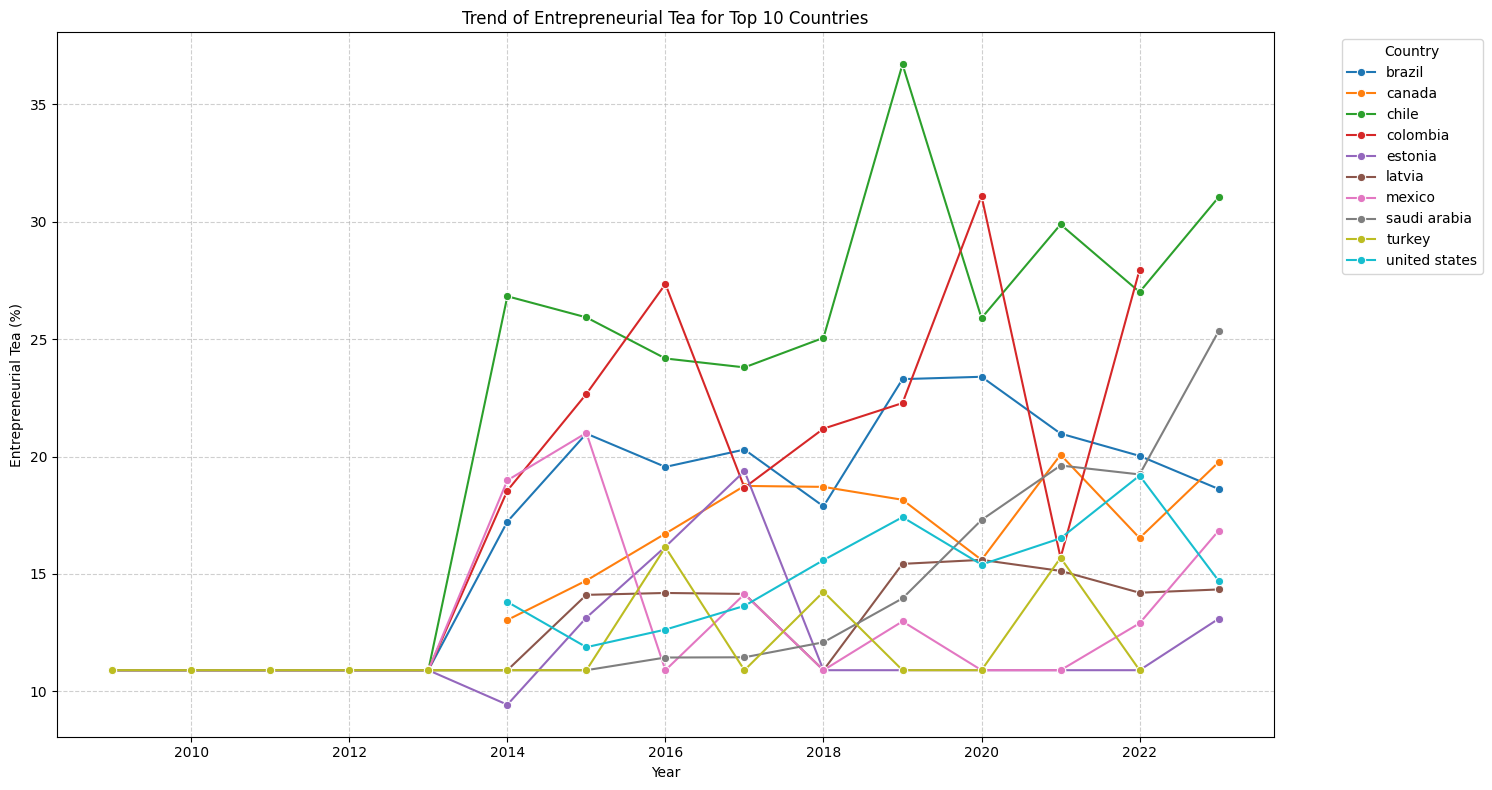


Analysis complete. Remember to interpret results cautiously, considering model assumptions and limitations, especially regarding causality.


In [12]:
# -*- coding: utf-8 -*-
"""
ESG Entrepreneurship Analysis - Modeling Entrepreneurial TEA (Corrected)

Steps:
1. Load and merge datasets.
2. Preprocess data.
3. Impute missing values using MICE (if necessary).
4. Check for multicollinearity using VIF.
5. Perform Panel Regression (Pooled, FE, RE, Two-Way FE) & Model Selection Tests.
6. Conduct Robustness Checks (Lagged Vars, Interactions, Subsamples - Examples).
7. Illustrate Granger Causality (Bivariate Example).
8. Train and evaluate Random Forest & XGBoost (for prediction/importance).
9. Visualize TEA for top 10 countries.
10. Emphasize interpretation and limitations.
"""

# -------------------------------------
# 1. Load Libraries & Data
# -------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
# !pip install linearmodels # Uncomment and run this line in Colab if needed
from linearmodels.panel import PanelOLS, RandomEffects, PooledOLS
from collections import OrderedDict
import scipy.stats as stats
from statsmodels.tsa.stattools import grangercausalitytests

print("Libraries loaded.")

# --- File Paths ---
esg_file = '/content/ESG_panel_processed_WorldBank.csv'
entrepreneur_file = '/content/merged_entrepreneur_data_prepared.xlsx'

# --- Load Data ---
try:
    print("Attempting to load ESG data with comma separator...")
    df_esg = pd.read_csv(esg_file, sep=',')
    if 'Year' not in df_esg.columns or 'Country' not in df_esg.columns:
         raise ValueError("ESG data missing 'Country' or 'Year' column after loading.")
    print("ESG data loaded successfully with separated columns.")
except FileNotFoundError:
    print(f"Error: ESG file '{esg_file}' not found. Please upload it.")
    exit()
except Exception as e:
    print(f"Error loading ESG file: {e}")
    exit()

try:
    df_entrepreneur = pd.read_excel(entrepreneur_file)
    print("Entrepreneur data loaded successfully.")
except FileNotFoundError:
    print(f"Error: Entrepreneur file '{entrepreneur_file}' not found. Please upload it.")
    exit()
except Exception as e:
    print(f"Error loading Entrepreneur file: {e}")
    exit()

# Display initial info
print("\n--- ESG Data Info ---")
df_esg.info(verbose=False)
print("\n--- Entrepreneur Data Info ---")
df_entrepreneur.info(verbose=False)


# -------------------------------------
# 2. Preprocessing and Merging
# -------------------------------------
print("\nStarting Preprocessing and Merging...")
df_esg.rename(columns={'Country': 'country', 'Year': 'year'}, inplace=True)
df_entrepreneur.rename(columns={'country': 'country', 'year': 'year'}, inplace=True)

df_esg['year'] = pd.to_numeric(df_esg['year'], errors='coerce').astype('Int64')
df_entrepreneur['year'] = pd.to_numeric(df_entrepreneur['year'], errors='coerce').astype('Int64')

df_esg['country'] = df_esg['country'].str.lower().str.strip()
df_entrepreneur['country'] = df_entrepreneur['country'].str.lower().str.strip()

merged_df = pd.merge(df_esg, df_entrepreneur, on=['country', 'year'], how='inner')
print(f"Merged DataFrame shape: {merged_df.shape}")

if merged_df.empty:
    print("Error: Merged DataFrame is empty.")
    exit()
else:
    # --- Define Dependent Variable ---
    dependent_var = 'entrepreneurial_tea'
    print(f"\n*** Using '{dependent_var}' as the dependent variable ***\n")

    # Identify numeric columns and potential features
    numeric_cols = merged_df.select_dtypes(include=np.number).columns.tolist()
    potential_features = [col for col in numeric_cols if col not in ['year', dependent_var]]

    # Ensure DV is numeric and drop NA rows for DV
    merged_df[dependent_var] = pd.to_numeric(merged_df[dependent_var], errors='coerce')
    initial_rows = len(merged_df)
    merged_df.dropna(subset=[dependent_var], inplace=True)
    print(f"Rows before DV NA drop: {initial_rows}, Rows after: {len(merged_df)}")
    if merged_df.empty:
        print("Error: No data remaining after dropping missing dependent variable values.")
        exit()

    # Coerce features to numeric
    for col in potential_features:
         if col in merged_df.columns:
            merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

    print("Preprocessing complete.")

    # -------------------------------------
    # 3. Impute Missing Values (MICE) - Optional if needed
    # -------------------------------------
    print("\nChecking for missing values before imputation...")
    cols_to_impute = potential_features + [dependent_var]
    cols_to_impute = [col for col in cols_to_impute if col in merged_df.columns]
    missing_counts = merged_df[cols_to_impute].isnull().sum()
    total_missing = missing_counts.sum()
    print(f"Total missing values in numeric columns to be potentially imputed: {total_missing}")

    if total_missing > 0:
        print("Starting MICE imputation...")
        impute_df_subset = merged_df[cols_to_impute].copy()
        mice_imputer = IterativeImputer(max_iter=10, random_state=42, tol=1e-3, verbose=0)
        print("Fitting MICE imputer...")
        imputed_data_np = mice_imputer.fit_transform(impute_df_subset)
        print("MICE imputation transform complete.")
        imputed_df_subset = pd.DataFrame(imputed_data_np, columns=cols_to_impute, index=merged_df.index)

        imputed_df = merged_df[['country', 'year']].copy()
        imputed_df = imputed_df.loc[imputed_df_subset.index]
        imputed_df = pd.concat([imputed_df, imputed_df_subset], axis=1)
        print("MICE imputation process finished.")
    else:
        print("No missing values found in the selected numeric columns. Skipping MICE.")
        imputed_df = merged_df.copy()

    print("\nMissing values after imputation step (%):")
    print((imputed_df[cols_to_impute].isnull().sum() / len(imputed_df) * 100).sort_values(ascending=False).head(10))

    # -------------------------------------
    # 4. Check for Multicollinearity (VIF)
    # -------------------------------------
    print("\nCalculating Variance Inflation Factor (VIF)...")
    X_vif_check = imputed_df[potential_features].copy()
    X_vif_check = X_vif_check.dropna(axis=1, how='all')
    X_vif_check = X_vif_check.loc[:, X_vif_check.apply(pd.Series.nunique) > 1]

    high_vif_features = []
    extreme_vif_features = []
    vif_data = None

    if not X_vif_check.empty:
        X_vif_const = sm.add_constant(X_vif_check, has_constant='add')
        vif_data = pd.DataFrame()
        vif_data["feature"] = X_vif_const.columns
        try:
            vif_data["VIF"] = [variance_inflation_factor(X_vif_const.values, i) for i in range(X_vif_const.shape[1])]
            vif_data = vif_data[vif_data["feature"] != "const"].sort_values(by="VIF", ascending=False)
            print("\nVIF Scores (Top 15):")
            print(vif_data.head(15))
            threshold = 10
            high_vif_features = vif_data[vif_data["VIF"] > threshold]["feature"].tolist()
            extreme_vif_features = vif_data[vif_data["VIF"] > 100]["feature"].tolist()
            if high_vif_features:
                print(f"\nWarning: High VIF (> {threshold}) detected for: {high_vif_features}")
                if extreme_vif_features:
                     print(f"Note: Extremely high VIF (> 100) for: {extreme_vif_features}.")
            else:
                print(f"\nNo significant multicollinearity detected (VIF <= {threshold}).")
        except Exception as e:
             print(f"Error during VIF calculation: {e}")
             vif_data = None
    else:
        print("No valid features remaining for VIF calculation.")

    # -------------------------------------
    # 5. Panel Regression Models & Tests
    # -------------------------------------
    print("\n--- Panel Regression Models & Selection Tests ---")

    panel_data = imputed_df.copy().set_index(['country', 'year'])
    y_panel = panel_data[dependent_var]

    panel_features_base = [f for f in potential_features if f in panel_data.columns]
    cols_to_remove_panel = ['adult_population', 'number_entrepreneur_llc', 'new_business_density_rate']
    if vif_data is not None and extreme_vif_features:
        cols_to_remove_panel.extend(extreme_vif_features)
    cols_to_remove_panel = list(set(cols_to_remove_panel))

    print(f"Removing these features for PanelOLS: {cols_to_remove_panel}")
    X_panel_vars = [f for f in panel_features_base if f not in cols_to_remove_panel]

    X_panel_df = panel_data[X_panel_vars]

    constant_cols = X_panel_df.columns[X_panel_df.nunique(dropna=False) <= 1]
    if not constant_cols.empty:
        print(f"Dropping constant columns: {list(constant_cols)}")
        X_panel_df = X_panel_df.drop(columns=constant_cols)

    X_panel_with_const = sm.add_constant(X_panel_df)
    print(f"Panel models will use {len(X_panel_df.columns)} predictors.")

    results_pooled = None
    results_fe_entity = None
    results_fe_two_way = None
    results_re = None
    hausman_stat = None
    hausman_p = None
    f_pooled_stat = None
    f_pooled_p = None
    f_joint_twoway_stat = None
    f_joint_twoway_p = None
    r2_within_entity = None
    r2_within_twoway = None
    time_effects_significant = False

    try:
        print("\nFitting Pooled OLS...")
        model_pooled = PooledOLS(y_panel, X_panel_with_const)
        results_pooled = model_pooled.fit(cov_type='clustered', cluster_entity=True)

        print("Fitting Fixed Effects (Entity)...")
        model_fe_entity = PanelOLS(y_panel, X_panel_with_const, entity_effects=True, drop_absorbed=True)
        results_fe_entity = model_fe_entity.fit(cov_type='clustered', cluster_entity=True)
        f_pooled_stat = results_fe_entity.f_pooled
        f_pooled_p = results_fe_entity.f_pooled.pval
        r2_within_entity = results_fe_entity.rsquared_within

        print("Fitting Fixed Effects (Entity + Time)...")
        model_fe_two_way = PanelOLS(y_panel, X_panel_with_const, entity_effects=True, time_effects=True, drop_absorbed=True)
        results_fe_two_way = model_fe_two_way.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
        r2_within_twoway = results_fe_two_way.rsquared_within
        f_joint_twoway_stat = results_fe_two_way.f_statistic.stat
        f_joint_twoway_p = results_fe_two_way.f_statistic.pval

        print("Fitting Random Effects...")
        model_re = RandomEffects(y_panel, X_panel_with_const)
        results_re = model_re.fit(cov_type='clustered', cluster_entity=True)

        print("\nPerforming Hausman Test...")
        if r2_within_twoway is not None and r2_within_entity is not None:
             time_effects_significant = (r2_within_twoway > r2_within_entity + 0.01)
             preferred_fe_results = results_fe_two_way if time_effects_significant else results_fe_entity
             fe_model_name_for_hausman = "Two-Way FE" if time_effects_significant else "Entity FE"
             print(f"Comparing RE against {fe_model_name_for_hausman} for Hausman test.")

             params_fe = preferred_fe_results.params
             params_re = results_re.params
             cov_fe = preferred_fe_results.cov
             cov_re = results_re.cov
             common_params = params_fe.index.intersection(params_re.index).drop('const', errors='ignore')

             params_diff = params_fe[common_params] - params_re[common_params]
             try:
                 cov_diff = cov_fe.loc[common_params, common_params] - cov_re.loc[common_params, common_params]
                 inv_cov_diff = np.linalg.inv(cov_diff)
                 hausman_stat = params_diff.T @ inv_cov_diff @ params_diff
                 degrees_freedom = len(common_params)
                 hausman_p = 1 - stats.chi2.cdf(hausman_stat, degrees_freedom)
                 print(f"Hausman Test Statistic: {hausman_stat:.4f}")
                 print(f"Hausman Test P-value: {hausman_p:.4f}")
             except np.linalg.LinAlgError:
                 print("Could not compute Hausman test (covariance difference matrix may be singular).")
                 hausman_p = None
        else:
            print("Skipping Hausman test as R-squared values needed for comparison are missing.")
            hausman_p = None

    except np.linalg.LinAlgError as lae:
         print(f"Linear Algebra Error during Panel Regression: {lae}")
         if 'model_fe_entity' not in locals() or results_fe_entity is None: r2_within_entity = None
         if 'model_fe_two_way' not in locals() or results_fe_two_way is None: r2_within_twoway = None
    except Exception as e:
        print(f"Error during Panel Model Fitting or Testing: {e}")
        if 'model_fe_entity' not in locals() or results_fe_entity is None: r2_within_entity = None
        if 'model_fe_two_way' not in locals() or results_fe_two_way is None: r2_within_twoway = None

    # --- Model Selection Decision ---
    print("\n--- Panel Model Selection Guidance ---")
    preferred_model_type = "Undetermined"
    final_panel_results = None

    if f_pooled_p is not None:
        print(f"F-test for Poolability (Entity Effects vs Pooled) p-value: {f_pooled_p:.4f}")
        if f_pooled_p < 0.05:
            print("--> Reject Pooled OLS (Entity effects are significant).")
            if r2_within_twoway is not None and r2_within_entity is not None:
                time_effects_significant = (r2_within_twoway > r2_within_entity + 0.01)
                print(f"Time Effects significant (based on R2-within increase > 0.01)? {'Yes' if time_effects_significant else 'No'}")
            else:
                print("Could not determine significance of time effects (R-squared missing).")
                time_effects_significant = False

            if hausman_p is not None:
                print(f"Hausman Test p-value: {hausman_p:.4f}")
                if hausman_p < 0.05:
                    print("--> Reject RE model (Endogeneity likely). FE is preferred.")
                    if time_effects_significant:
                         preferred_model_type = "Two-Way Fixed Effects"
                         final_panel_results = results_fe_two_way
                    else:
                         preferred_model_type = "Entity Fixed Effects"
                         final_panel_results = results_fe_entity
                else:
                    print("--> Cannot reject RE model. RE may be more efficient.")
                    preferred_model_type = "Random Effects"
                    final_panel_results = results_re
            else:
                print("Hausman test inconclusive or failed. Defaulting to FE for robustness.")
                if time_effects_significant:
                     preferred_model_type = "Two-Way Fixed Effects (Default)"
                     final_panel_results = results_fe_two_way
                else:
                     preferred_model_type = "Entity Fixed Effects (Default)"
                     final_panel_results = results_fe_entity
        else:
            print("--> Cannot reject Pooled OLS (Entity effects may not be significant).")
            preferred_model_type = "Pooled OLS"
            final_panel_results = results_pooled
    else:
        print("Could not perform F-test for poolability (FE model likely failed).")

    if final_panel_results:
        print(f"\n--- Summary for Statistically Preferred Model ({preferred_model_type}) ---")
        print(final_panel_results.summary)
    else:
        print("\nCould not determine or fit a preferred panel model due to errors.")

    # -------------------------------------
    # 6. Robustness Checks (Examples)
    # -------------------------------------
    print("\n--- Robustness Checks (Illustrative Examples) ---")

    # --- 6.1 Lagged Predictor ---
    print("\nExample Robustness Check 1: Lagged Predictor (rule_law_estimate)")
    lagged_var = 'rule_law_estimate'
    lagged_df = imputed_df.copy()
    lagged_df[f'{lagged_var}_lag1'] = lagged_df.groupby('country')[lagged_var].shift(1)
    lagged_df.dropna(subset=[f'{lagged_var}_lag1'], inplace=True)

    if not lagged_df.empty and final_panel_results is not None: # Check if base model ran
        try:
            panel_data_lag = lagged_df.set_index(['country', 'year'])
            y_panel_lag = panel_data_lag[dependent_var]
            # Use the same *pruned* feature set as the final preferred model
            X_panel_lag_vars = [f for f in final_panel_results.params.index if f not in ['const', lagged_var]] + [f'{lagged_var}_lag1']
            # Ensure all required columns exist in panel_data_lag
            X_panel_lag_vars = [f for f in X_panel_lag_vars if f in panel_data_lag.columns]
            X_panel_lag = panel_data_lag[X_panel_lag_vars]
            X_panel_lag = sm.add_constant(X_panel_lag)

            if preferred_model_type == "Random Effects":
                 model_lag = RandomEffects(y_panel_lag, X_panel_lag)
                 results_lag = model_lag.fit(cov_type='clustered', cluster_entity=True)
                 print(f"RE model with lagged '{lagged_var}':")
                 print(results_lag.summary.tables[1]) # Print only params table for brevity
            elif "Fixed Effects" in preferred_model_type:
                 model_lag = PanelOLS(y_panel_lag, X_panel_lag,
                                       entity_effects=True,
                                       time_effects=("Two-Way" in preferred_model_type),
                                       drop_absorbed=True)
                 results_lag = model_lag.fit(cov_type='clustered', cluster_entity=True, cluster_time=("Two-Way" in preferred_model_type))
                 print(f"FE model ({preferred_model_type}) with lagged '{lagged_var}':")
                 print(results_lag.summary.tables[1])
            else: # Pooled OLS
                 model_lag = PooledOLS(y_panel_lag, X_panel_lag)
                 results_lag = model_lag.fit(cov_type='clustered', cluster_entity=True)
                 print(f"Pooled OLS model with lagged '{lagged_var}':")
                 print(results_lag.summary.tables[1])

        except Exception as e:
            print(f"Error running model with lagged variable: {e}")
    elif final_panel_results is None:
        print("Skipping lagged variable check because preferred panel model failed.")
    else:
        print("Not enough data to create lagged variable or run model.")

    # --- 6.2 Interaction Term ---
    print("\nExample Robustness Check 2: Interaction Term (rule_law * internet)")
    interaction_df = imputed_df.copy()
    var1 = 'rule_law_estimate'
    var2 = 'individuals_using_the_internet_population'

    if final_panel_results is not None and var1 in final_panel_results.params.index and var2 in final_panel_results.params.index:
        interaction_df[f'{var1}_x_{var2}'] = interaction_df[var1] * interaction_df[var2]
        panel_data_interact = interaction_df.set_index(['country', 'year'])
        y_panel_interact = panel_data_interact[dependent_var]
        # Use same features as preferred model + interaction term
        X_panel_interact_vars = [f for f in final_panel_results.params.index if f != 'const'] + [f'{var1}_x_{var2}']
        X_panel_interact = panel_data_interact[X_panel_interact_vars]
        X_panel_interact = sm.add_constant(X_panel_interact)

        try:
            if preferred_model_type == "Random Effects":
                 model_interact = RandomEffects(y_panel_interact, X_panel_interact)
                 results_interact = model_interact.fit(cov_type='clustered', cluster_entity=True)
                 print(f"RE model with interaction '{var1}_x_{var2}':")
                 print(results_interact.summary.tables[1])
            elif "Fixed Effects" in preferred_model_type:
                 model_interact = PanelOLS(y_panel_interact, X_panel_interact,
                                          entity_effects=True,
                                          time_effects=("Two-Way" in preferred_model_type),
                                          drop_absorbed=True)
                 results_interact = model_interact.fit(cov_type='clustered', cluster_entity=True, cluster_time=("Two-Way" in preferred_model_type))
                 print(f"FE model ({preferred_model_type}) with interaction '{var1}_x_{var2}':")
                 print(results_interact.summary.tables[1])
            else:
                 model_interact = PooledOLS(y_panel_interact, X_panel_interact)
                 results_interact = model_interact.fit(cov_type='clustered', cluster_entity=True)
                 print(f"Pooled OLS model with interaction '{var1}_x_{var2}':")
                 print(results_interact.summary.tables[1])

        except Exception as e:
            print(f"Error running model with interaction term: {e}")
    elif final_panel_results is None:
         print("Skipping interaction check because preferred panel model failed.")
    else:
        print(f"Skipping interaction term: One or both variables ({var1}, {var2}) not in preferred panel model features.")

    # --- 6.3 Subsample Analysis (Placeholder Structure) ---
    print("\nExample Robustness Check 3: Subsample Analysis (Structure)")
    print("--> Placeholder: Define subsample (e.g., based on income level, time period) and rerun preferred model.")

    # -------------------------------------
    # 7. Granger Causality Test (Illustrative Bivariate Example)
    # -------------------------------------
    print("\n--- Granger Causality Test (Illustrative Example) ---")
    print("Note: Bivariate test for ONE country.")
    country_counts = imputed_df['country'].value_counts()
    example_country = country_counts[country_counts >= 10].index[0] if not country_counts[country_counts >= 10].empty else None
    var_gc_1 = dependent_var
    var_gc_2 = 'rule_law_estimate'

    if example_country and var_gc_1 in imputed_df.columns and var_gc_2 in imputed_df.columns:
        print(f"Running Granger causality test for '{example_country}' between '{var_gc_1}' and '{var_gc_2}'")
        gc_df = imputed_df[imputed_df['country'] == example_country][[var_gc_1, var_gc_2]].dropna().astype(float) # Ensure float
        max_lag = 3
        if len(gc_df) > max_lag + 5:
            try:
                # Ensure stationarity (example using diff, more formal tests like ADF needed in practice)
                gc_diff = gc_df.diff().dropna()
                if len(gc_diff) > max_lag + 5:
                     print("Using first differences for Granger test (assuming non-stationarity)")
                     gc_results = grangercausalitytests(gc_diff[[var_gc_1, var_gc_2]], maxlag=max_lag, verbose=False)
                     for lag, test_dict in gc_results.items():
                         f_test_p = test_dict[0]['ssr_ftest'][1]
                         print(f"  Lag {lag}: P-value ({var_gc_2}_diff -> {var_gc_1}_diff): {f_test_p:.4f}")
                else:
                    print("Not enough data points after differencing.")

            except Exception as e:
                print(f"Could not run Granger causality test: {e}")
        else:
            print(f"Skipping Granger causality for {example_country}: Insufficient data points ({len(gc_df)}) for max lag {max_lag}.")
    else:
        print("Skipping Granger causality example.")

    # -------------------------------------
    # 8 & 9. Random Forest & XGBoost (DV: entrepreneurial_tea)
    # -------------------------------------
    print(f"\n--- Random Forest Regressor (DV: {dependent_var}) ---")
    ml_features = potential_features + ['year']
    ml_features = [col for col in ml_features if col in imputed_df.columns and col != dependent_var]
    X = imputed_df[ml_features]
    y = imputed_df[dependent_var]

    if not X.empty and not y.empty:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        print(f"Training/Test Split Shapes: X_train {X_train.shape}, X_test {X_test.shape}")
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, min_samples_split=5, oob_score=True)
        rf_model.fit(X_train, y_train)
        y_pred_rf = rf_model.predict(X_test)
        mse_rf = mean_squared_error(y_test, y_pred_rf)
        rmse_rf = np.sqrt(mse_rf)
        r2_rf = r2_score(y_test, y_pred_rf)

        # --- Corrected OOB Score Printing ---
        print(f"Random Forest RMSE: {rmse_rf:.4f}")
        print(f"Random Forest R-squared: {r2_rf:.4f}")
        oob_score_str = "N/A"
        if hasattr(rf_model, 'oob_score_') and rf_model.oob_score_:
             try:
                 oob_score_str = f"{rf_model.oob_score_:.4f}"
             except Exception:
                 oob_score_str = "Error formatting"
        print(f"Random Forest OOB Score: {oob_score_str}")
        # --- End Corrected OOB ---

        importances_rf = pd.DataFrame({'Feature': X_train.columns,'Importance': rf_model.feature_importances_}).sort_values(by='Importance', ascending=False)
        print("RF Top 10 Features:\n", importances_rf.head(10))

        print(f"\n--- XGBoost Regressor (DV: {dependent_var}) ---")
        xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1, early_stopping_rounds=10)
        eval_set = [(X_test, y_test)]
        xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)
        y_pred_xgb = xgb_model.predict(X_test)
        mse_xgb = mean_squared_error(y_test, y_pred_xgb)
        rmse_xgb = np.sqrt(mse_xgb)
        r2_xgb = r2_score(y_test, y_pred_xgb)
        print(f"XGBoost RMSE: {rmse_xgb:.4f}, R2: {r2_xgb:.4f}")
        importances_xgb = pd.DataFrame({'Feature': X_train.columns,'Importance': xgb_model.feature_importances_}).sort_values(by='Importance', ascending=False)
        print("XGBoost Top 10 Features:\n", importances_xgb.head(10))
    else:
         print("Skipping ML models due to empty X or y.")

    # -------------------------------------
    # 10. Visualization
    # -------------------------------------
    print(f"\n--- Visualizing '{dependent_var.replace('_',' ').title()}' for Top 10 Countries ---")
    country_avg_rate = imputed_df.groupby('country')[dependent_var].mean().sort_values(ascending=False)
    top_10_countries = country_avg_rate.head(10).index.tolist()
    print(f"Top 10 countries by average '{dependent_var}': {top_10_countries}")
    top_10_df = imputed_df[imputed_df['country'].isin(top_10_countries)].copy()

    plt.figure(figsize=(15, 8))
    sns.lineplot(data=top_10_df, x='year', y=dependent_var, hue='country', marker='o', palette='tab10')
    plt.title(f'Trend of {dependent_var.replace("_", " ").title()} for Top 10 Countries')
    plt.xlabel('Year')
    plt.ylabel(f'{dependent_var.replace("_", " ").title()} (%)')
    plt.ticklabel_format(style='plain', axis='y')
    plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    print("\nAnalysis complete. Remember to interpret results cautiously, considering model assumptions and limitations, especially regarding causality.")